In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import argparse
import cv2
import os
from imutils import paths

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
INIT_LR = 1e-3
EPOCHS = 25
BS = 8

In [3]:
imagePaths = list(paths.list_images("dataset"))
data = []
labels = []

for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the image, swap color channels, and resize it to be a fixed
	# 224x224 pixels while ignoring aspect ratio
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

In [4]:
data = np.array(data) / 255.0
labels = np.array(labels)

In [5]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [6]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [7]:
trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

In [8]:
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

In [9]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [10]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [11]:
for layer in baseModel.layers:
    layer.trainable = False

In [12]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [13]:
H = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
21/21 [==============================] - 3s 124ms/step - loss: 0.8574 - accuracy: 0.5357 - val_loss: 0.6391 - val_accuracy: 0.6818
Epoch 2/25
21/21 [==============================] - 2s 84ms/step - loss: 0.6775 - accuracy: 0.6402 - val_loss: 0.5663 - val_accuracy: 0.8636
Epoch 3/25
21/21 [==============================] - 2s 84ms/step - loss: 0.5852 - accuracy: 0.7134 - val_loss: 0.5052 - val_accuracy: 0.9318
Epoch 4/25
21/21 [==============================] - 2s 84ms/step - loss: 0.5077 - accuracy: 0.7927 - val_loss: 0.4561 - val_accuracy: 0.9091
Epoch 5/25
21/21 [==============================] - 2s 82ms/step - loss: 0.4891 - accuracy: 0.7744 - val_loss: 0.4172 - val_accuracy: 0.9091
Epoch 6/25
21/21 [==============================] - 2s 83ms/step - loss: 0.4904 - accuracy: 0.7622 - val_loss: 0.4078 - val_accuracy: 0.9318
Epoch 7/25
21/21 [==============================] - 2s 85ms/step - loss: 0.39

In [14]:
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)

In [15]:
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

In [16]:
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[22  0]
 [ 2 20]]
acc: 0.9545
sensitivity: 1.0000
specificity: 0.9091


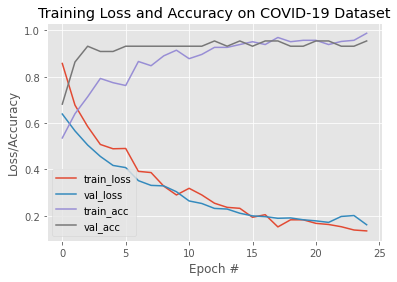

In [17]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [18]:
model.save("covid19.model", save_format="h5")